In [16]:
import os
from glob import glob 
import time
import random
from datetime import datetime

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR 
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

In [17]:
def random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

random_seed(42)

In [18]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
train_data_path = '../data2/train/'
test_data_path = '../data2/test/'

# model config
model_name = 'efficientnet_b4' #resnet50' 'efficientnet-b0', ...

# training config
img_size = 224
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
num_workers = 0
log_interval = 370

In [19]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, data_path, ids, targets=None, transform=None):
        self.ids = ids
        self.targets = targets
        self.data_path = data_path
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ID = self.ids[idx]
        image_path = os.path.join(self.data_path, ID)
        img = np.array(Image.open(image_path))
        if self.transform:
            img = self.transform(image=img)['image']
        if self.targets is not None:
            return img, self.targets[idx]
        else:
            return img

In [20]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_loss(loss_fn, pred, labels_a, labels_b, lam):
    return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [21]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, output, target):
        log_prob = torch.nn.functional.log_softmax(output, dim=-1)
        nll_loss = -log_prob.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_prob.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [22]:
def train_per_epoch(epoch, model, train_loader, loss_fn, optimizer, train_step, scheduler):
    preds_list = []
    labels_list = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        current_loss = 0.0

        if (batch_idx + 1) % 5 == 0:
            imgs, labels_a, labels_b, lambda_ = mixup_data(images, labels)
            output = model(imgs)
            loss = mixup_loss(loss_fn=loss_fn, pred=output, labels_a=labels_a, labels_b=labels_b, lam=lambda_)
        else: 
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

            preds_list.extend(preds.detach().cpu().numpy())
            labels_list.extend(labels.detach().cpu().numpy())

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

        if batch_idx % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = accuracy_score(labels_list, preds_list)
            train_f1 = f1_score(labels_list, preds_list, average='macro')

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.4f}, Train F1 Score: {:.4f}".format(
                epoch, 
                batch_idx * len(images), 
                len(train_loader) * len(images), 
                100 * batch_idx / len(train_loader), 
                train_loss, 
                train_acc,
                train_f1))

            if wandb is not None:
                wandb.log({
                    "Loss/Train": train_loss,
                    "Accuracy/Train": train_acc,
                    "F1 Score/Train": train_f1,
                    "Image/Train": wandb.Image(images),
                    "Output/Train": wandb.Histogram(outputs.detach().cpu().numpy()),
                    "Preds/Train": wandb.Histogram(preds.detach().cpu().numpy()),
                    "Labels/Train": wandb.Histogram(labels.detach().cpu().numpy()),  
                }, step=train_step)
        train_step += 1
    scheduler.step()
    return train_step, current_loss / len(train_loader), accuracy_score(labels_list, preds_list), f1_score(labels_list, preds_list, average='macro')
    
def validation(model, val_loader, loss_fn, train_step):
    val_preds_list = []
    val_labels_list = []
    with torch.no_grad():
        val_loss = 0.0
        model.eval()

        for val_idx, (val_images, val_labels) in enumerate(val_loader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            
            val_preds_list.extend(val_preds.detach().cpu().numpy())
            val_labels_list.extend(val_labels.detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = accuracy_score(val_labels_list, val_preds_list)
        val_epoch_f1 = f1_score(val_labels_list, val_preds_list, average='macro')

        if wandb is not None:
            wandb.log({
                "Loss/Val": val_epoch_loss,
                "Accuracy/Val": val_epoch_acc,
                "F1 Score/Val": val_epoch_f1,
                "Image/Val": wandb.Image(val_images),
                "Output/Val": wandb.Histogram(val_outputs.detach().cpu().numpy()),
                "Preds/Val": wandb.Histogram(val_preds.detach().cpu().numpy()),
                "Labels/Val": wandb.Histogram(val_labels.detach().cpu().numpy()),  
            }, step=train_step )

        print("Validation dataset: Val Loss: {:.6f}, Val Acc: {:.4f}, Val F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_acc, val_epoch_f1))
    return val_epoch_loss, val_epoch_acc, val_epoch_f1

In [23]:
df = pd.read_csv('../data2/modify_target_add_transformed_train.csv')
sample_submission_df = pd.read_csv("../data2/sample_submission.csv")

In [24]:
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
print(len(df_train), len(df_val))

118316 29580


In [25]:
train_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
valid_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [26]:
# Dataset 정의
train_dataset = ImageDataset(
    train_data_path,
    df_train['ID'].values,
    df_train['target'].values,
    transform=train_transform
)
valid_dataset = ImageDataset(
    train_data_path,
    df_val['ID'].values,
    df_val['target'].values,
    transform=valid_transform
)
test_dataset = ImageDataset(
    test_data_path,
    sample_submission_df['ID'].values,
    transform=test_transform
)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

118316 29580 3140


In [27]:
# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [28]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = LabelSmoothingCrossEntropyLoss(smoothing=0.1)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)
optimizer_name = type(optimizer).__name__

scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{model_name}-{optimizer_name}_optim-{LR}_lr_label_smoothing"
log_dir = f"runs/{run_name}"

project_name = 'DTC-ch'
run_tags=[project_name]
wandb.init(
    project=project_name,
    name=run_name,
    tags=run_tags,
    config={"lr": LR, "model_name": model_name, "optimizer_name": optimizer_name},
    reinit=True
)
     

Accuracy/Train,▁█
F1 Score/Train,▁█
Loss/Train,█▁
Accuracy/Train,0.85743
F1 Score/Train,0.85693
Loss/Train,0.00189


In [29]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

In [30]:
save_point = 0
early_stop_count = 0
path = os.path.join(model_path, 'model.ckpt')

train_result = []
val_result = []

train_step = 0
for epoch in range(1, EPOCHS + 1):
    train_step, train_loss, train_acc, train_f1 = train_per_epoch(epoch, model, train_loader, loss_fn, optimizer, train_step, scheduler)
    val_loss, val_acc, val_f1 = validation(model, valid_loader, loss_fn, train_step)
    train_result.append([train_loss, train_acc, train_f1])
    val_result.append([val_loss, val_acc, val_f1])

    if val_f1 > save_point:
        save_point = val_f1
        save_dir = os.path.dirname(path)
        torch.save(model, os.path.join(save_dir, f'val_f1-{val_f1}-{path.split("/")[-1]}'))
        print('Saved Model!!!')
        early_stop_count = 0
    else:
        early_stop_count += 1
    
    if early_stop_count == 3:
        break

Train Epoch: 1 [0/118336 (0%)]	Train Loss: 0.008492, Train Acc: 0.0312, Train F1 Score: 0.0154
Train Epoch: 1 [23680/118336 (20%)]	Train Loss: 0.002012, Train Acc: 0.8574, Train F1 Score: 0.8570
Train Epoch: 1 [47360/118336 (40%)]	Train Loss: 0.001804, Train Acc: 0.9110, Train F1 Score: 0.9105
Train Epoch: 1 [71040/118336 (60%)]	Train Loss: 0.001668, Train Acc: 0.9316, Train F1 Score: 0.9313
Train Epoch: 1 [94720/118336 (80%)]	Train Loss: 0.001622, Train Acc: 0.9429, Train F1 Score: 0.9427
Validation dataset: Val Loss: 0.010096, Val Acc: 0.9792, Val F1 Score: 0.9793
Saved Model!!!
Train Epoch: 2 [0/118336 (0%)]	Train Loss: 0.001642, Train Acc: 1.0000, Train F1 Score: 1.0000
Train Epoch: 2 [23680/118336 (20%)]	Train Loss: 0.001586, Train Acc: 0.9933, Train F1 Score: 0.9934
Train Epoch: 2 [47360/118336 (40%)]	Train Loss: 0.001655, Train Acc: 0.9945, Train F1 Score: 0.9946
Train Epoch: 2 [71040/118336 (60%)]	Train Loss: 0.001630, Train Acc: 0.9954, Train F1 Score: 0.9954
Train Epoch: 2 [9

In [32]:
best_model = torch.load('../code/runs/2024-02-12T05:50:33-efficientnet_b4/models/val_f1-0.9974499034946445-model.ckpt')

In [33]:
# for valid
val_preds_list = []
val_targets_list = []

with torch.no_grad():
    val_loss = 0.0
    val_correct = 0.0
    best_model.eval()

    for val_idx, (val_images, val_labels) in enumerate(valid_loader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)

        val_outputs = best_model(val_images)
        _, val_preds = torch.max(val_outputs, 1)

        val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
        
        val_preds_list.extend(val_preds.detach().cpu().numpy())
        val_targets_list.extend(val_labels.detach().cpu().numpy())

In [34]:
accuracy_score(val_targets_list, val_preds_list)

0.9974645030425964

In [35]:
df_val['pred'] = val_preds_list

In [36]:
df_val[df_val['target'] == df_val['pred']].target.count()

29505

In [59]:
df_val[df_val['target'] != df_val['pred']].target.value_counts()

target
3     29
7     21
4      9
14     7
11     3
10     2
13     2
1      1
6      1
Name: count, dtype: int64

In [ ]:
# 7, 14, 3

In [43]:
error_df = df_val[df_val['target'] != df_val['pred']]

In [ ]:
# 너무 roation이 되어 주요 부분이 많이 삭제가 된 것 같음, noise와 blur가 너무 들어 간거 같음 
# 변환이 너무 심하게 되었음 

In [37]:
preds_list = []

best_model.eval()
for image in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = best_model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


In [38]:
assert (sample_submission_df['ID'] == test_dataset.ids).all()

In [39]:
pred_df = pd.DataFrame(test_dataset.ids, columns=['ID'])
pred_df['target'] = preds_list

In [40]:
pred_df.to_csv("pred5.csv", index=False)

In [96]:
!pwd

/data/ephemeral/home/code


In [41]:
pred3 = pd.read_csv('../code/pred3.csv')
pred4 = pd.read_csv('../code/pred5.csv')

In [42]:
temp = pred3.merge(pred4, how='left', on=['ID'])

In [71]:
temp[temp['target_x'] != temp['target_y']]

,ID,target_x,target_y
19,017ba667291b53c6.jpg,11,6
49,04fc58802ef2f7a6.jpg,3,7
54,0546cab14c4ee65b.jpg,4,3
70,071a06f75055347b.jpg,4,10
74,075ed6e4c487debc.jpg,14,7
...,...,...,...
3081,fb947536ad14961a.jpg,14,7
3090,fc2a40463c5fbc62.jpg,3,7
3092,fc4e7d28b421674b.jpg,7,14
3097,fc9cbd311e6be876.jpg,3,7


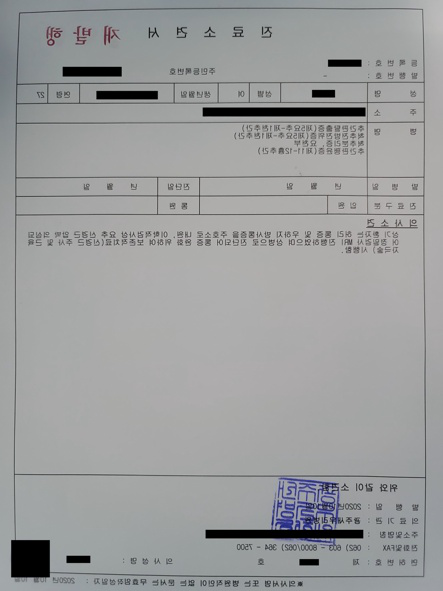

In [70]:
Image.open('../data2/test/3cf69d787241e31a.jpg')